In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model


In [ ]:
# Cell 1: Configuration and Constants
IMAGE_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 30
WEIGHT_INIT = 0.05 # Hệ số khởi tạo trọng số ban đầu
WEIGHT_DECAY = 1e-4 # Hệ số phạt L2 (regularization)

ALPHA_DICT = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'R', 14: 'S', 15: 'T',
    16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2',
    24: '3', 25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"
}

print("Configuration loaded successfully!")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Total Classes: {len(ALPHA_DICT)}")

Configuration loaded successfully!
Image Size: 28x28
Batch Size: 128
Epochs: 30
Total Classes: 32


In [ ]:
# Cell 2: Load and Process Dataset

def load_character_data(data_path, image_size=28):
 
    # Label mappings
    digit_labels = {
        "0": 21, "1": 22, "2": 23, "3": 24, "4": 25,
        "5": 26, "6": 27, "7": 28, "8": 29, "9": 30, "BG": 31
    }

    alpha_labels = {
        "A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7,
        "K": 8, "L": 9, "M": 10, "N": 11, "P": 12, "R": 13, "S": 14,
        "T": 15, "U": 16, "V": 17, "X": 18, "Y": 19, "Z": 20
    }

    X_digits, y_digits = [], []
    X_alphas, y_alphas = [], []

    # Load digit data
    for folder_name in os.listdir(data_path):
        if folder_name in digit_labels:
            label = digit_labels[folder_name]
            folder_path = os.path.join(data_path, folder_name)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (image_size, image_size), cv2.INTER_AREA)
                img = img.reshape((image_size, image_size, 1))
                X_digits.append(img)
                y_digits.append(label)

    # Load alpha data
    for folder_name in os.listdir(data_path):
        if folder_name in alpha_labels:
            label = alpha_labels[folder_name]
            folder_path = os.path.join(data_path, folder_name)

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (image_size, image_size), cv2.INTER_AREA)
                img = img.reshape((image_size, image_size, 1))
                X_alphas.append(img)
                y_alphas.append(label)

    X_digits = np.array(X_digits)
    y_digits = np.array(y_digits)
    X_alphas = np.array(X_alphas)
    y_alphas = np.array(y_alphas)

    print(f"Loaded {len(X_digits)} digit samples")
    print(f"Loaded {len(X_alphas)} alpha samples")

    return X_digits, y_digits, X_alphas, y_alphas

# Example usage:
data_path = "/content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecognition/data/characters_thi_giac_may_tinh/char_bien_so"
X_digits, y_digits, X_alphas, y_alphas = load_character_data(data_path, IMAGE_SIZE)

Loaded 1000 digit samples
Loaded 2100 alpha samples


In [ ]:
# Cell 3: Split and Save Dataset

def split_and_save_data(X_digits, y_digits, X_alphas, y_alphas,
                        output_dir="/content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecognition/data/characters_thi_giac_may_tinh/char_bien_so",
                        test_size=0.3, val_ratio=0.5, random_state=42):
    
    # Split digit data: 70% train, 15% val, 15% test
    X_train_digits, X_temp_digits, y_train_digits, y_temp_digits = train_test_split(
        X_digits, y_digits, test_size=test_size, random_state=random_state, stratify=y_digits
    )
    X_val_digits, X_test_digits, y_val_digits, y_test_digits = train_test_split(
        X_temp_digits, y_temp_digits, test_size=val_ratio,
        random_state=random_state, stratify=y_temp_digits
    )

    # Split alpha data: 70% train, 15% val, 15% test
    X_train_alphas, X_temp_alphas, y_train_alphas, y_temp_alphas = train_test_split(
        X_alphas, y_alphas, test_size=test_size, random_state=random_state, stratify=y_alphas
    )
    X_val_alphas, X_test_alphas, y_val_alphas, y_test_alphas = train_test_split(
        X_temp_alphas, y_temp_alphas, test_size=val_ratio,
        random_state=random_state, stratify=y_temp_alphas
    )

    # Save digit data
    np.save(f"{output_dir}digits_X_train.npy", X_train_digits)
    np.save(f"{output_dir}digits_y_train.npy", y_train_digits)
    np.save(f"{output_dir}digits_X_val.npy", X_val_digits)
    np.save(f"{output_dir}digits_y_val.npy", y_val_digits)
    np.save(f"{output_dir}digits_X_test.npy", X_test_digits)
    np.save(f"{output_dir}digits_y_test.npy", y_test_digits)

    # Save alpha data
    np.save(f"{output_dir}alphas_X_train.npy", X_train_alphas)
    np.save(f"{output_dir}alphas_y_train.npy", y_train_alphas)
    np.save(f"{output_dir}alphas_X_val.npy", X_val_alphas)
    np.save(f"{output_dir}alphas_y_val.npy", y_val_alphas)
    np.save(f"{output_dir}alphas_X_test.npy", X_test_alphas)
    np.save(f"{output_dir}alphas_y_test.npy", y_test_alphas)

    # Print statistics
    print("=" * 50)
    print("DATASET SPLIT SUMMARY")
    print("=" * 50)
    print("\nDigits:")
    print(f"  Training set:   {X_train_digits.shape[0]:6} samples ({X_train_digits.shape[0]/len(X_digits)*100:.1f}%)")
    print(f"  Validation set: {X_val_digits.shape[0]:6} samples ({X_val_digits.shape[0]/len(X_digits)*100:.1f}%)")
    print(f"  Test set:       {X_test_digits.shape[0]:6} samples ({X_test_digits.shape[0]/len(X_digits)*100:.1f}%)")

    print("\nAlphas:")
    print(f"  Training set:   {X_train_alphas.shape[0]:6} samples ({X_train_alphas.shape[0]/len(X_alphas)*100:.1f}%)")
    print(f"  Validation set: {X_val_alphas.shape[0]:6} samples ({X_val_alphas.shape[0]/len(X_alphas)*100:.1f}%)")
    print(f"  Test set:       {X_test_alphas.shape[0]:6} samples ({X_test_alphas.shape[0]/len(X_alphas)*100:.1f}%)")
    print("=" * 50)

    return {
        'digits': {
            'train': (X_train_digits, y_train_digits),
            'val': (X_val_digits, y_val_digits),
            'test': (X_test_digits, y_test_digits)
        },
        'alphas': {
            'train': (X_train_alphas, y_train_alphas),
            'val': (X_val_alphas, y_val_alphas),
            'test': (X_test_alphas, y_test_alphas)
        }
    }

split_data = split_and_save_data(X_digits, y_digits, X_alphas, y_alphas)

DATASET SPLIT SUMMARY

Digits:
  Training set:      700 samples (70.0%)
  Validation set:    150 samples (15.0%)
  Test set:          150 samples (15.0%)

Alphas:
  Training set:     1470 samples (70.0%)
  Validation set:    315 samples (15.0%)
  Test set:          315 samples (15.0%)


Loaded train dataset:
  Digits: 700 samples
  Alphas: 1470 samples (x8 = 11760)
  Total: 12460 samples
Loaded val dataset:
  Digits: 150 samples
  Alphas: 315 samples (x1 = 315)
  Total: 465 samples
Loaded test dataset:
  Digits: 150 samples
  Alphas: 315 samples (x1 = 315)
  Total: 465 samples


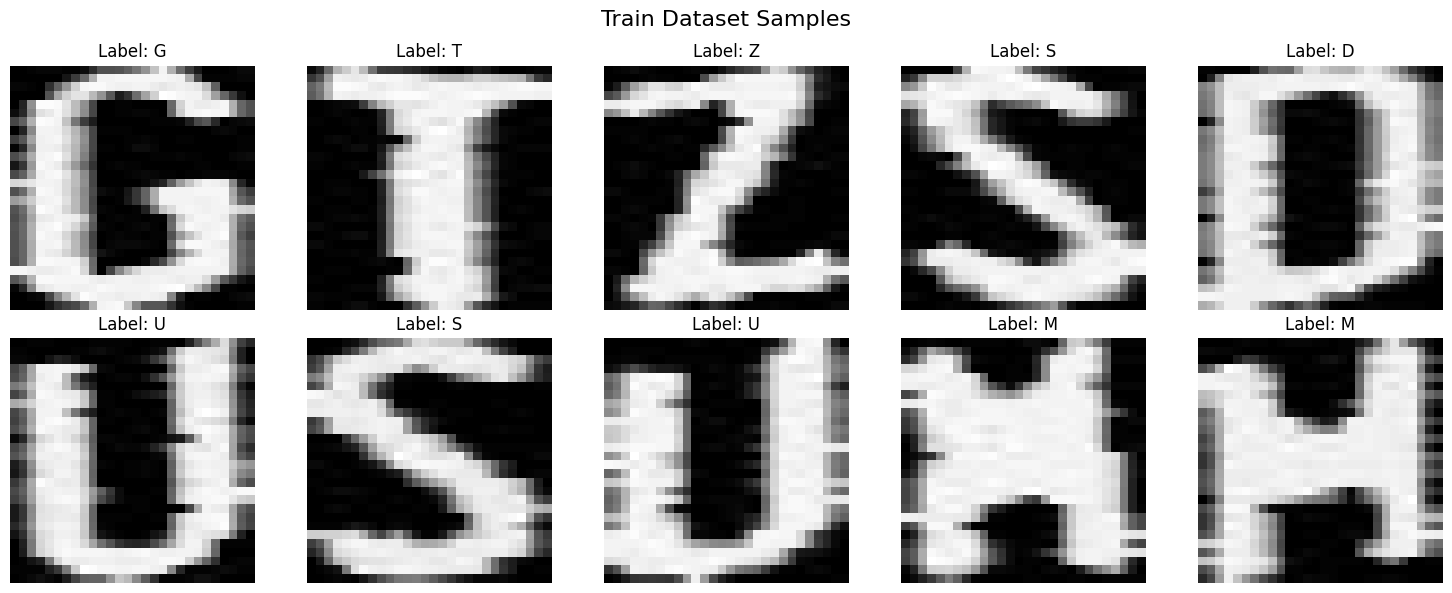

X_train shape: (12460, 28, 28, 1)
y_train shape: (12460, 32)


In [ ]:
# Cell 4: Dataset Generator Class

class Datasets:

    def __init__(self,
                 data_dir="/content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecognition/data/characters_thi_giac_may_tinh/char_bien_so",
                 mode='train', alpha_augmentation=8):

        self.data_dir = data_dir
        self.mode = mode
        self.alpha_augmentation = alpha_augmentation if mode == 'train' else 1
        self.all_data = []

        self._load_data()

    def _load_data(self):
        """Load digit and alpha data based on mode."""
        # Load digits
        X_digits = np.load(f"{self.data_dir}digits_X_{self.mode}.npy")
        y_digits = np.load(f"{self.data_dir}digits_y_{self.mode}.npy")
        digits_data = list(zip(X_digits, y_digits))

        # Load alphas
        X_alphas = np.load(f"{self.data_dir}alphas_X_{self.mode}.npy")
        y_alphas = np.load(f"{self.data_dir}alphas_y_{self.mode}.npy")
        alphas_data = list(zip(X_alphas, y_alphas))

        # Add digit data
        self.all_data.extend(digits_data)

        # Add alpha data with augmentation
        for i in range(len(alphas_data) * self.alpha_augmentation):
            self.all_data.append(alphas_data[i % len(alphas_data)])

        print(f"Loaded {self.mode} dataset:")
        print(f"  Digits: {len(digits_data)} samples")
        print(f"  Alphas: {len(alphas_data)} samples (x{self.alpha_augmentation} = {len(alphas_data) * self.alpha_augmentation})")
        print(f"  Total: {len(self.all_data)} samples")

    def generate(self, shuffle=True, num_classes=32):
   
        if shuffle:
            np.random.shuffle(self.all_data)

        images = np.array([img for img, _ in self.all_data])
        labels = np.array([label for _, label in self.all_data])
        labels = keras.utils.to_categorical(labels, num_classes=num_classes)

        return images, labels

    def visualize_samples(self, n_samples=10, alpha_dict=ALPHA_DICT):
        """Visualize random samples from the dataset."""
        indices = np.random.choice(len(self.all_data), n_samples, replace=False)

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i, idx in enumerate(indices):
            img, label = self.all_data[idx]
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f"Label: {alpha_dict[label]}")
            axes[i].axis('off')

        plt.suptitle(f'{self.mode.capitalize()} Dataset Samples', fontsize=16)
        plt.tight_layout()
        plt.show()

# Dataset Generate
train_dataset = Datasets(mode='train', alpha_augmentation=8)
val_dataset = Datasets(mode='val')
test_dataset = Datasets(mode='test')

# Visualize samples
train_dataset.visualize_samples(n_samples=10)

# Generate data
X_train, y_train = train_dataset.generate()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [ ]:
# Cell 5: Build CNN Model

def build_cnn_model(input_shape=(28, 28, 1), num_classes=32, learning_rate=1e-3):
   
    model = Sequential([
    
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        '''
        Fully connected layers
        Flatten(): Làm phẳng tensor 3D -> 1D
        Dense(512, activation='relu'): Fully connected layer với 512 neuron và hàm kích hoạt ReLU
        Dense(32, activation='softmax'): Lớp đầu ra (32 lớp) <- softmax: tính xác suất cho từng lớp
        '''
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # y_pred_i = exp(z_i) / Σ exp(z_j): j = 1 -> 32
    ])

    # Compile model
    model.compile(
        loss="categorical_crossentropy", # L = -Σ [y_true_i * log(y_pred_i)]: i = 1 -> 32
        optimizer=optimizers.Adam(learning_rate),
        metrics=['acc']
    )

    return model

model = build_cnn_model(input_shape=(28, 28, 1), num_classes=32)
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,544 (736.50 KB)

 Trainable params: 188,544 (736.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 6: Training Function

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")

def calculate_f1_score(model, X, y_true_one_hot):
    """
    Calculate macro F1 score for the model.

    Parameters:
        model: Keras model
        X: Input data
        y_true_one_hot: True labels (one-hot encoded)

    Returns:
        Macro F1 score
    """
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true_one_hot, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

def train_model(model, train_dataset, val_dataset, output_dir,
                epochs=30, batch_size=128
                ):
    """
    Train the CNN model with F1 score tracking.

    Parameters:
        model: Compiled Keras model
        train_dataset: Training dataset (Datasets object)
        val_dataset: Validation dataset (Datasets object)
        epochs: Number of training epochs
        batch_size: Batch size for training
        output_dir: Directory to save models and metrics

    Returns:
        Dictionary containing training history
    """
    # Callbacks
    # Giảm lr khi val_acc không cải thiện
    reduce_lr = ReduceLROnPlateau(
        monitor='val_acc',
        factor=0.2,
        patience=5,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        f'{output_dir}weight.keras',
        save_best_only=True,
        monitor='val_acc',
        mode='max',
        verbose=1
    )

    # Generate data
    print("Generating training and validation data...")
    X_train, y_train = train_dataset.generate(shuffle=True)
    X_val, y_val = val_dataset.generate(shuffle=False)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # Training history
    history = {
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_loss': [],
        'val_loss': []
    }

    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 60)

        # Train for one epoch
        h = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=batch_size,
            callbacks=[checkpoint, reduce_lr],
            verbose=1
        )

        # Extract metrics
        train_acc = h.history['acc'][0]
        val_acc = h.history['val_acc'][0]
        train_loss = h.history['loss'][0]
        val_loss = h.history['val_loss'][0]

        # Calculate F1 scores
        train_f1 = calculate_f1_score(model, X_train, y_train)
        val_f1 = calculate_f1_score(model, X_val, y_val)

        # Store metrics
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print metrics
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    # Save final model
    model.save(f'{output_dir}')
    print(f"\n{'='*60}")
    print(f"Training completed! Model saved as {output_dir}")
    print("="*60)

    return history

history = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    output_dir="/content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecognition/data/model/character_recognition.keras"
)

Generating training and validation data...
Training data shape: (12460, 28, 28, 1)
Validation data shape: (465, 28, 28, 1)

STARTING TRAINING

Epoch 1/30
------------------------------------------------------------
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - acc: 0.2042 - loss: 2.8396
Epoch 1: val_acc improved from -inf to 0.72688, saving model to /content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecognition/data/model/character_recognition.kerasweight.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - acc: 0.2066 - loss: 2.8304 - val_acc: 0.7269 - val_loss: 0.9152 - learning_rate: 0.0010
Train - Loss: 1.9287, Acc: 0.4371, F1: 0.7358
Val   - Loss: 0.9152, Acc: 0.7269, F1: 0.6665

Epoch 2/30
------------------------------------------------------------
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - acc: 0.8697 - loss: 0.4277
Epoch 1: val_acc improved from 0.72688 to 0.84731, saving model to /content/drive/MyDrive/Colab Notebooks/DigitalImageProcessing/LicensePlateRecogn

FINAL MODEL EVALUATION

Train Set:
  Loss:     0.0020
  Accuracy: 0.9997
  F1 Score: 0.9988

Validation Set:
  Loss:     0.1918
  Accuracy: 0.9656
  F1 Score: 0.9656

Test Set:
  Loss:     0.1779
  Accuracy: 0.9806
  F1 Score: 0.9806

CLASSIFICATION REPORTS

Validation Set Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        15
           B       0.80      0.80      0.80        15
           C       1.00      1.00      1.00        15
           D       0.88      1.00      0.94        15
           E       1.00      1.00      1.00        15
           F       1.00      1.00      1.00        15
           G       1.00      1.00      1.00        15
           H       1.00      0.93      0.97        15
           K       1.00      1.00      1.00        15
           L       1.00      1.00      1.00        15
           M       0.94      1.00    

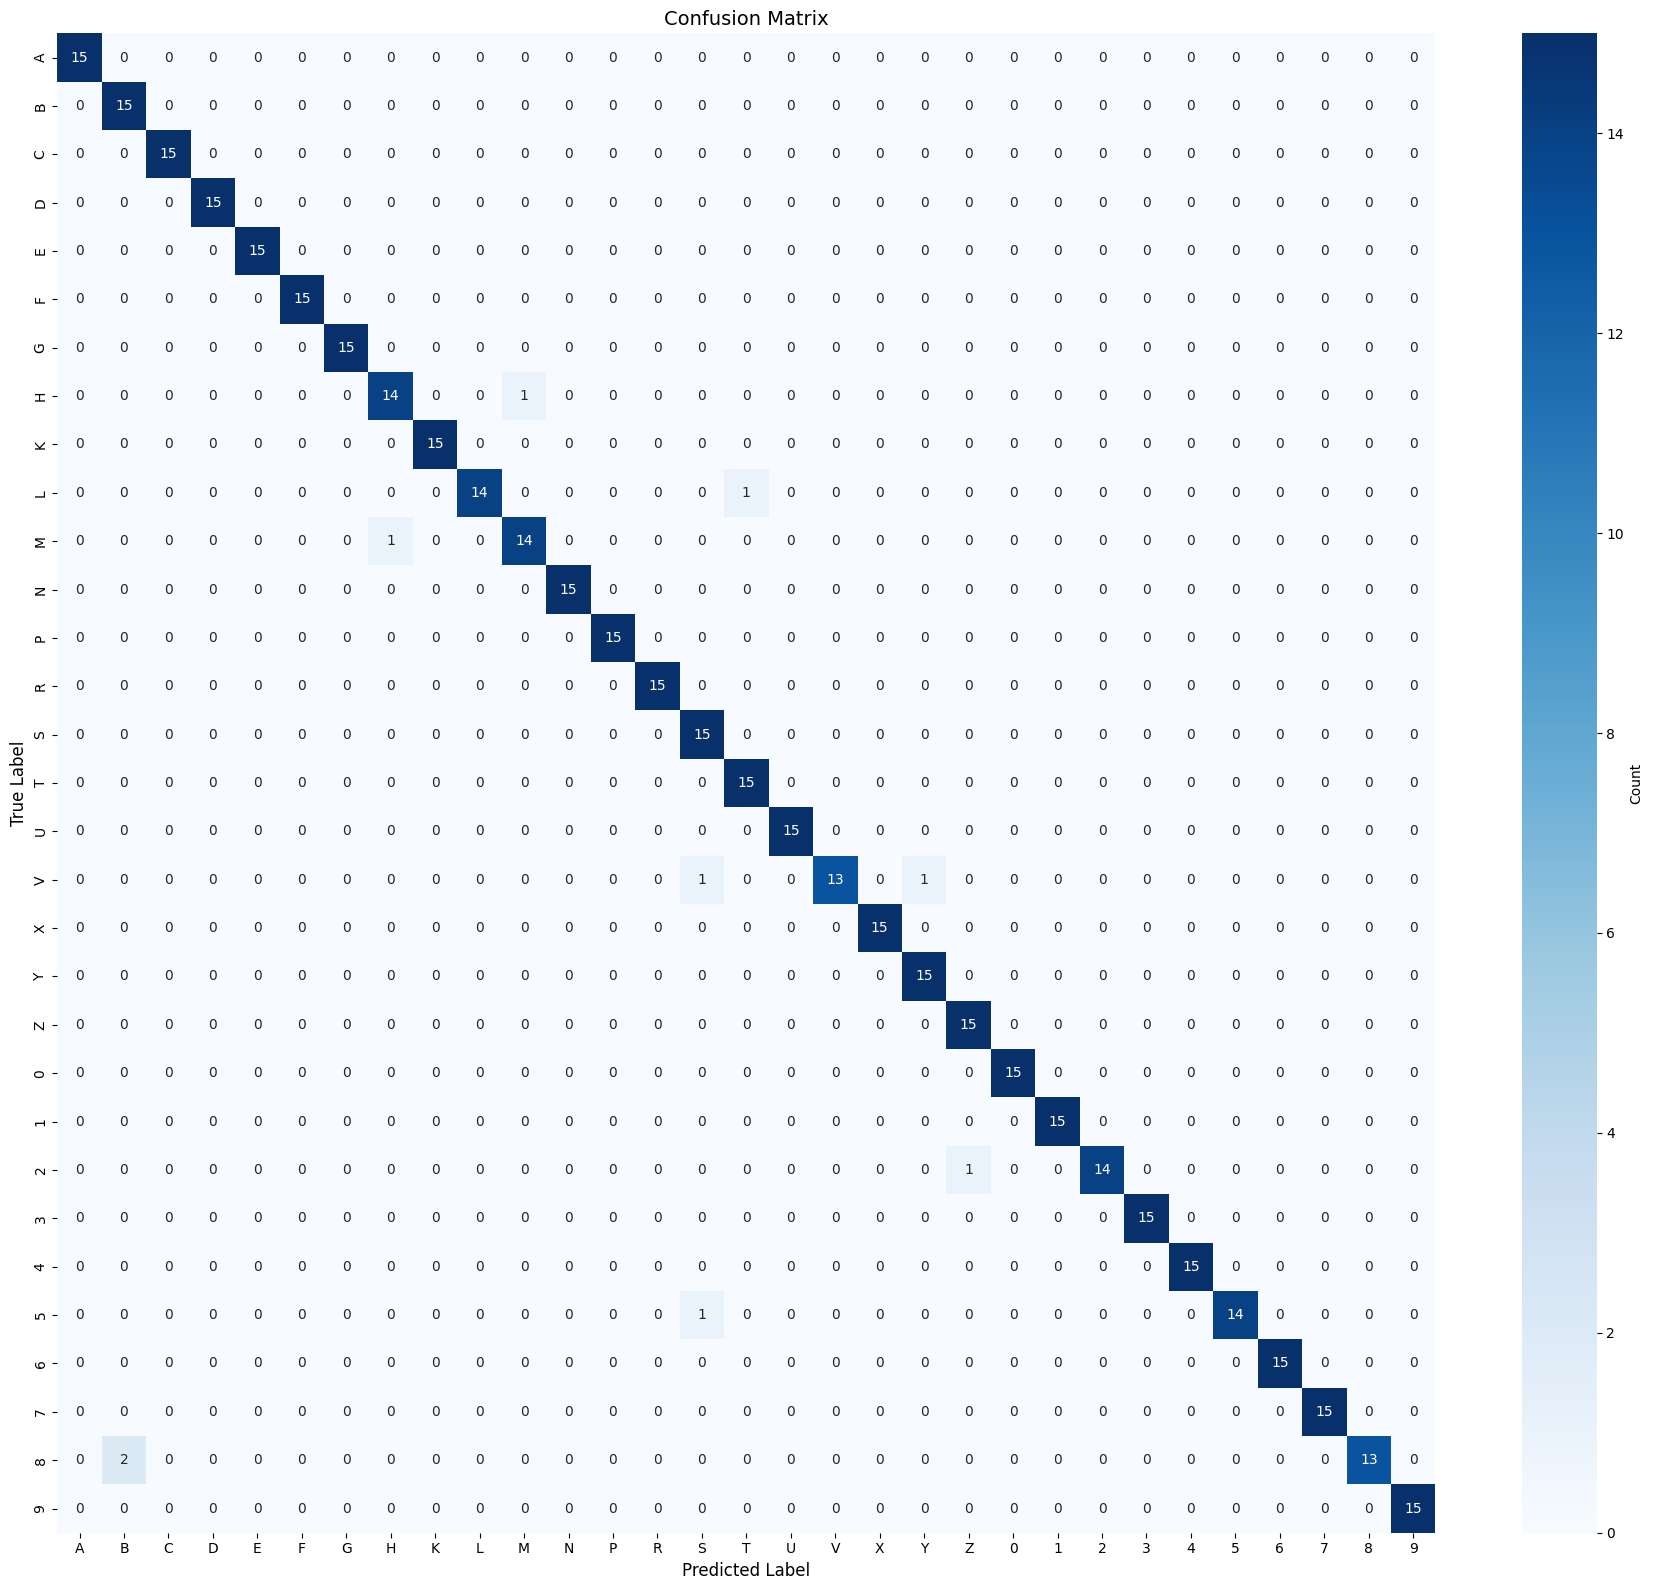

In [ ]:
# Cell 7: Model Evaluation

def evaluate_model(model, train_dataset, val_dataset, test_dataset,
                   alpha_dict=ALPHA_DICT):
    """
    Evaluate model on all datasets and print detailed reports.

    Parameters:
        model: Trained Keras model
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
        alpha_dict: Dictionary mapping label indices to characters

    Returns:
        Dictionary containing evaluation metrics
    """
    # Generate data
    X_train, y_train = train_dataset.generate(shuffle=False)
    X_val, y_val = val_dataset.generate(shuffle=False)
    X_test, y_test = test_dataset.generate(shuffle=False)

    print("="*70)
    print("FINAL MODEL EVALUATION")
    print("="*70)

    results = {}

    # Evaluate on each dataset
    for name, X, y in [('Train', X_train, y_train),
                        ('Validation', X_val, y_val),
                        ('Test', X_test, y_test)]:

        # Calculate metrics
        loss, acc = model.evaluate(X, y, verbose=0)
        f1 = calculate_f1_score(model, X, y)

        results[name.lower()] = {
            'loss': loss,
            'accuracy': acc,
            'f1_score': f1
        }

        print(f"\n{name} Set:")
        print(f"  Loss:     {loss:.4f}")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1 Score: {f1:.4f}")

    # Detailed classification reports
    print("\n" + "="*70)
    print("CLASSIFICATION REPORTS")
    print("="*70)

    for name, X, y in [('Validation', X_val, y_val), ('Test', X_test, y_test)]:
        y_pred = model.predict(X, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y, axis=1)

        print(f"\n{name} Set Classification Report:")
        print("-" * 70)
        # Only show classes 0-30 (exclude background)
        target_names = [alpha_dict[i] for i in range(31)]
        print(classification_report(
            y_true_classes,
            y_pred_classes,
            target_names=target_names,
            zero_division=1
        ))

    return results

def plot_confusion_matrix(model, dataset, alpha_dict=ALPHA_DICT
                          # output_path="/content/drive/MyDrive/LicensePlateRecognition/visualization/confusion_matrix.png"
                          ):
    """
    Plot confusion matrix for a dataset.

    Parameters:
        model: Trained Keras model
        dataset: Dataset to evaluate
        alpha_dict: Dictionary mapping label indices to characters
        output_path: Path to save the confusion matrix plot
    """
    X, y = dataset.generate(shuffle=False)
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1)

    # Compute confusion matrix (exclude background class 31)
    cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(31))

    # Plot
    plt.figure(figsize=(18, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[alpha_dict[i] for i in range(31)],
                yticklabels=[alpha_dict[i] for i in range(31)],
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.tight_layout()
    # plt.savefig(output_path, dpi=150)
    plt.show()
    # print(f"Confusion matrix saved to: {output_path}")

results = evaluate_model(model, train_dataset, val_dataset, test_dataset)
plot_confusion_matrix(model, test_dataset)

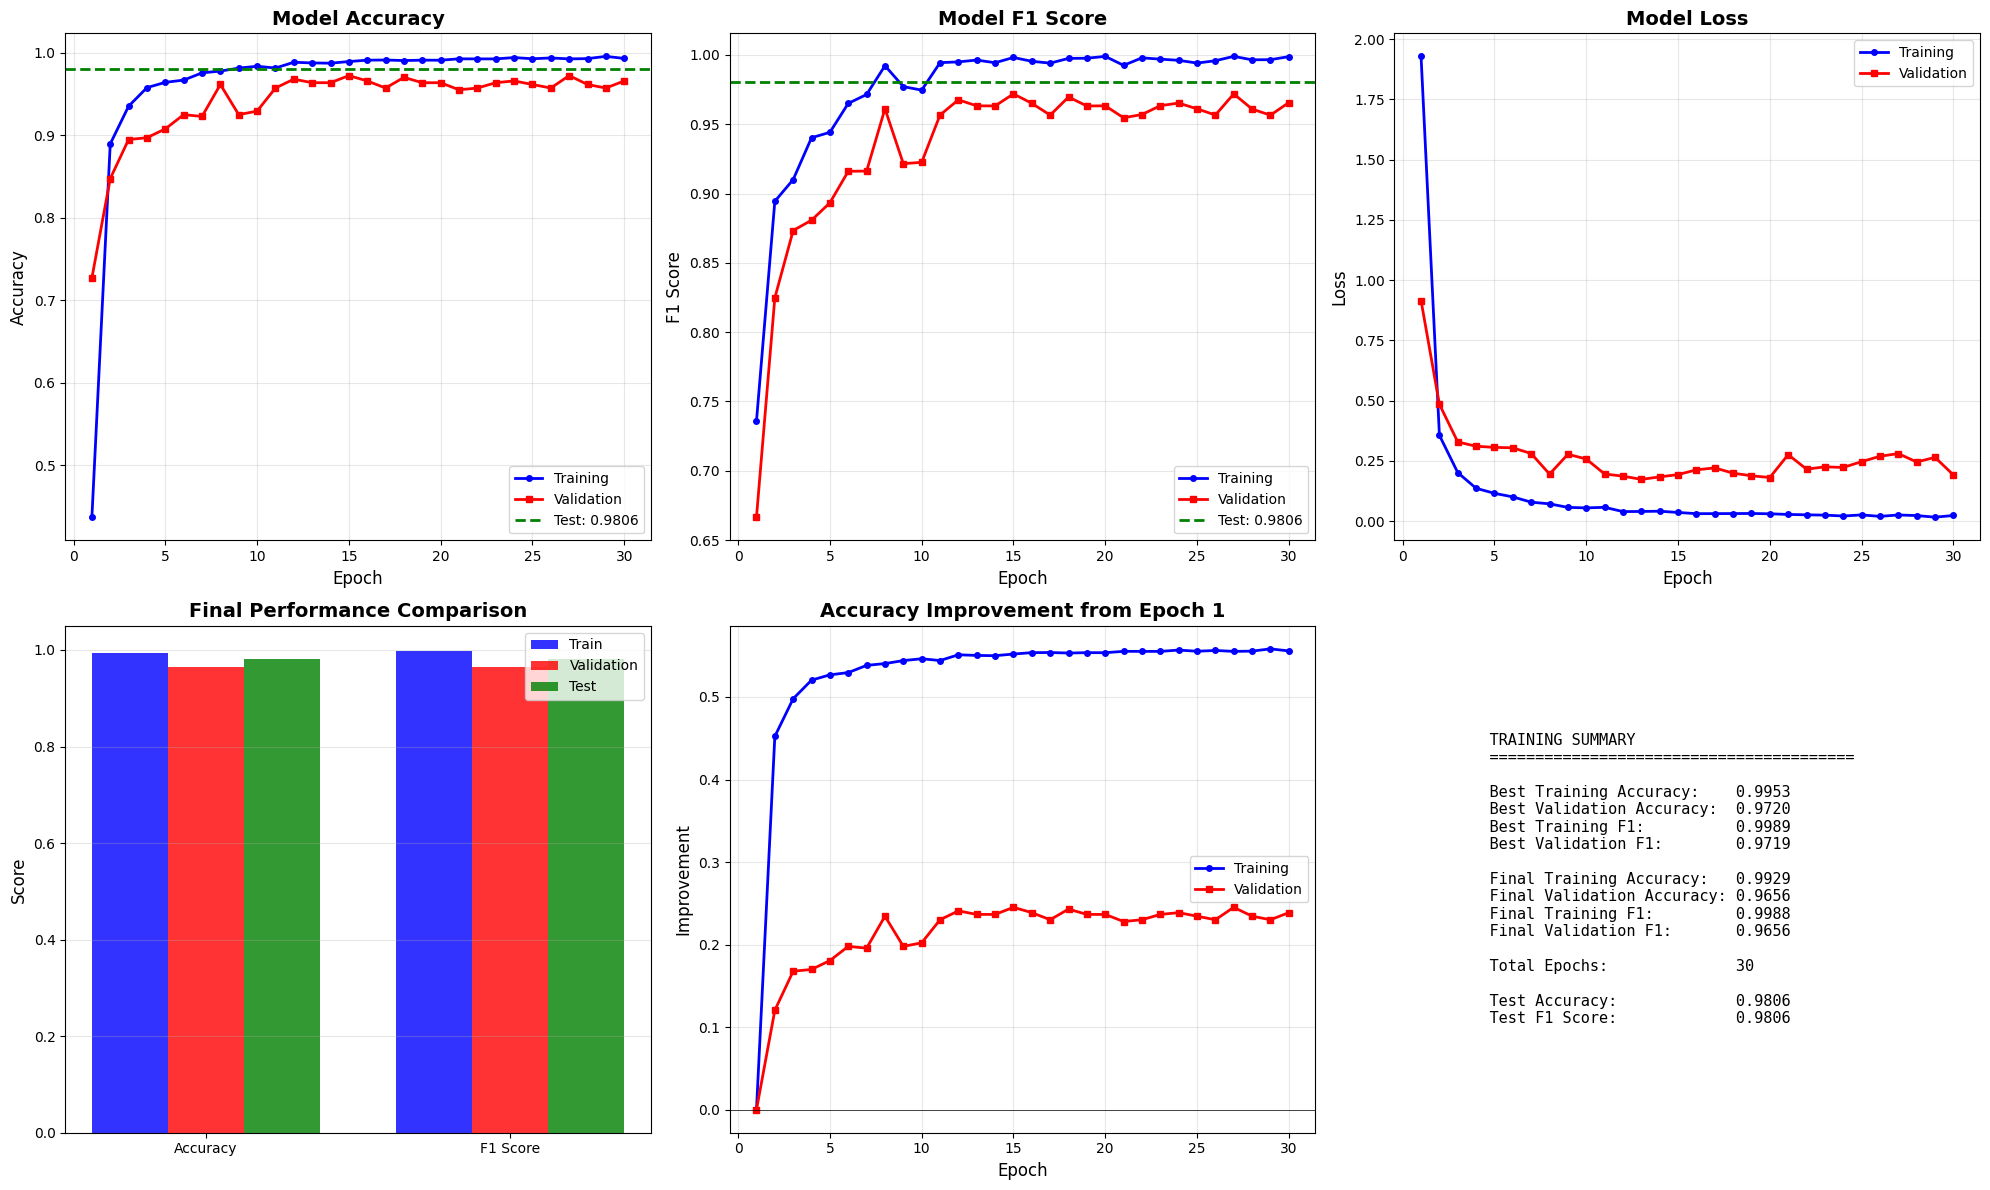

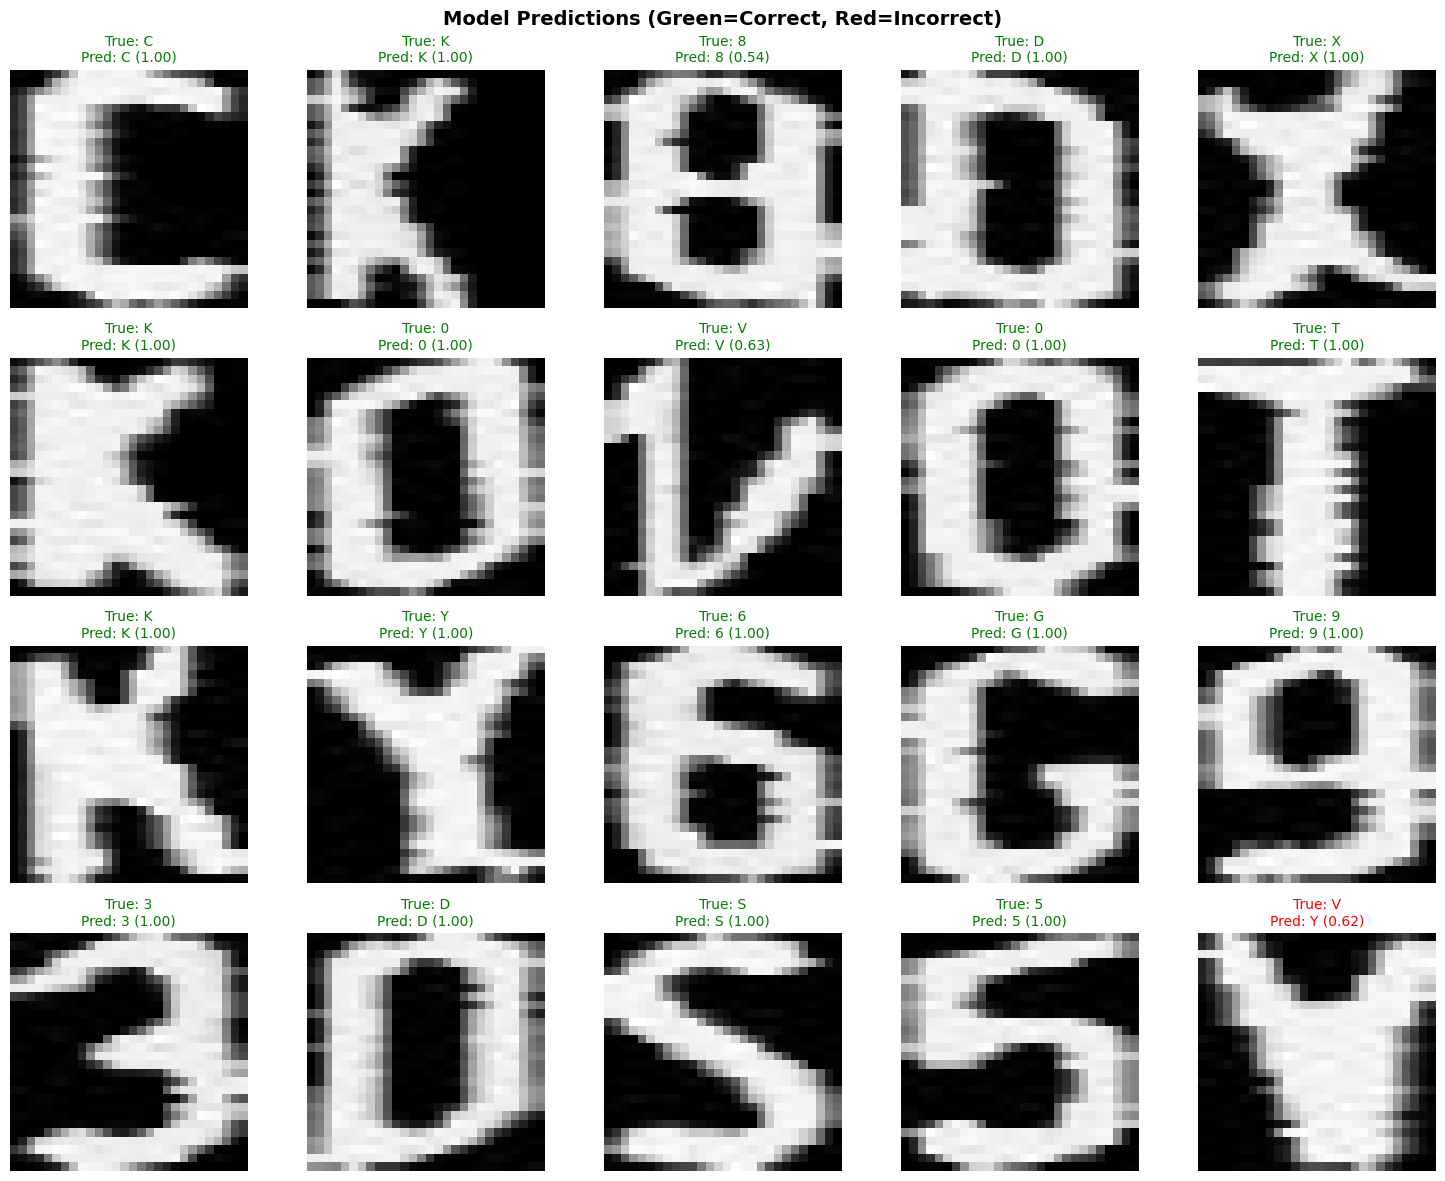

In [ ]:
# Cell 8: Visualization Functions

def plot_training_curves(history, test_acc=None, test_f1=None,
                         output_dir="/content/drive/MyDrive/LicensePlateRecognition/visualization/"):
    """
    Plot comprehensive training curves including accuracy, F1 score, and loss.

    Parameters:
        history: Training history dictionary from train_model()
        test_acc: Test accuracy (optional)
        test_f1: Test F1 score (optional)
        output_dir: Directory to save plots
    """
    epochs = range(1, len(history['train_acc']) + 1)

    # Create comprehensive plot
    fig = plt.figure(figsize=(20, 12))

    # 1. Accuracy curve
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(epochs, history['train_acc'], 'b-o', label='Training', linewidth=2, markersize=4)
    ax1.plot(epochs, history['val_acc'], 'r-s', label='Validation', linewidth=2, markersize=4)
    if test_acc is not None:
        ax1.axhline(y=test_acc, color='g', linestyle='--', linewidth=2,
                    label=f'Test: {test_acc:.4f}')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # 2. F1 Score curve
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(epochs, history['train_f1'], 'b-o', label='Training', linewidth=2, markersize=4)
    ax2.plot(epochs, history['val_f1'], 'r-s', label='Validation', linewidth=2, markersize=4)
    if test_f1 is not None:
        ax2.axhline(y=test_f1, color='g', linestyle='--', linewidth=2,
                    label=f'Test: {test_f1:.4f}')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('Model F1 Score', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # 3. Loss curve
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(epochs, history['train_loss'], 'b-o', label='Training', linewidth=2, markersize=4)
    ax3.plot(epochs, history['val_loss'], 'r-s', label='Validation', linewidth=2, markersize=4)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Loss', fontsize=12)
    ax3.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # 4. Final comparison bar chart
    ax4 = plt.subplot(2, 3, 4)
    metrics = ['Accuracy', 'F1 Score']
    train_final = [history['train_acc'][-1], history['train_f1'][-1]]
    val_final = [history['val_acc'][-1], history['val_f1'][-1]]

    x = np.arange(len(metrics))
    width = 0.25

    ax4.bar(x - width, train_final, width, label='Train', color='blue', alpha=0.8)
    ax4.bar(x, val_final, width, label='Validation', color='red', alpha=0.8)

    if test_acc is not None and test_f1 is not None:
        test_final = [test_acc, test_f1]
        ax4.bar(x + width, test_final, width, label='Test', color='green', alpha=0.8)

    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend(fontsize=10)
    ax4.grid(True, axis='y', alpha=0.3)
    ax4.set_ylim([0, 1.05])

    # 5. Accuracy improvement over epochs
    ax5 = plt.subplot(2, 3, 5)
    train_improvement = np.array(history['train_acc']) - history['train_acc'][0]
    val_improvement = np.array(history['val_acc']) - history['val_acc'][0]
    ax5.plot(epochs, train_improvement, 'b-o', label='Training', linewidth=2, markersize=4)
    ax5.plot(epochs, val_improvement, 'r-s', label='Validation', linewidth=2, markersize=4)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.set_ylabel('Improvement', fontsize=12)
    ax5.set_title('Accuracy Improvement from Epoch 1', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)

    # 6. Training summary statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    summary_text = f"""
    TRAINING SUMMARY
    {'='*40}

    Best Training Accuracy:    {max(history['train_acc']):.4f}
    Best Validation Accuracy:  {max(history['val_acc']):.4f}
    Best Training F1:          {max(history['train_f1']):.4f}
    Best Validation F1:        {max(history['val_f1']):.4f}

    Final Training Accuracy:   {history['train_acc'][-1]:.4f}
    Final Validation Accuracy: {history['val_acc'][-1]:.4f}
    Final Training F1:         {history['train_f1'][-1]:.4f}
    Final Validation F1:       {history['val_f1'][-1]:.4f}

    Total Epochs:              {len(epochs)}
    """

    if test_acc is not None and test_f1 is not None:
        summary_text += f"""
    Test Accuracy:             {test_acc:.4f}
    Test F1 Score:             {test_f1:.4f}
        """

    ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center')

    plt.tight_layout()
    # plt.savefig(f'{output_dir}training_curves_comprehensive.png', dpi=150, bbox_inches='tight')
    plt.show()

    # print(f"Comprehensive training curves saved to: {output_dir}training_curves_comprehensive.png")

def plot_sample_predictions(model, dataset, alpha_dict=ALPHA_DICT,
                           n_samples=20,
                            output_path="/content/drive/MyDrive/LicensePlateRecognition/visualization/predictions.png"):
    """
    Visualize model predictions on random samples.

    Parameters:
        model: Trained model
        dataset: Dataset to sample from
        alpha_dict: Dictionary mapping indices to labels
        n_samples: Number of samples to display
        output_path: Path to save the plot
    """
    X, y = dataset.generate(shuffle=True)
    indices = np.random.choice(len(X), n_samples, replace=False)

    predictions = model.predict(X[indices], verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y[indices], axis=1)

    rows = 4
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.ravel()

    for i in range(n_samples):
        axes[i].imshow(X[indices[i]].squeeze(), cmap='gray')

        true_label = alpha_dict[true_classes[i]]
        pred_label = alpha_dict[pred_classes[i]]
        confidence = predictions[i][pred_classes[i]]

        color = 'green' if true_classes[i] == pred_classes[i] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Model Predictions (Green=Correct, Red=Incorrect)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    # print(f"Sample predictions saved to: {output_path}")

plot_training_curves(history, test_acc=results['test']['accuracy'],
                    test_f1=results['test']['f1_score'])
plot_sample_predictions(model, test_dataset, n_samples=20)